# Dollar Cost Averaging (DCA) vs Lump Sum (LS)

> If you had 100K cash available in your bank and you are thinking of investing in a market index like the [S&P500](https://en.wikipedia.org/wiki/S%26P_500), then should you invest it 10K for the next 10 months or 100K today?

If you are thinking of this question, then congratulations! You are one step ahead than most who would simply jump on the bandwagon and follow mainstream advice. 

We can rarely be certain about one choice over another in practice but we can gain confidence if we apply a rigorous analytical approach to our decision. Here, we look to test two investment strategies, for a fixed amount of 100K on S&P500:

1. **Dollar Cost Averaging** (DCA)
2. **Lump Sum** (LS)

These strategies will be tested over the following parameters:

- **A large number of historical timepoints**: Such that the analysis can be generalized and answer probabilistic questions
- **Length of investment period**: 1, 3, 5, 10, 15, 20, 30 years
- **DCA periods**: What are the effects of investing, say 10K for 10 months vs 1K for 100 months (~8-9 years)?

## Setting up

We are interested in the S&P500 market index's price movements and will use yahoo finance `yfinance` to read prices for ticker **`SPY`** for the purposes of the analysis. [Seed](https://stackoverflow.com/questions/21494489/what-does-numpy-random-seed0-do) is set for reproducibility purposes. 

Since prices are only available for trading days, non-trading days will be filled forward with the last observed prices - this helps with the downstream backtesting strategy as a random choice of days will be picked as the start of an instance's investment day.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings

# Display settings
sns.set_theme(style="ticks", palette="pastel")
pd.options.display.float_format = "{:,.2f}".format
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# Set seed for reproducibility
np.random.seed(200)

,Close
Date,
1993-01-29 00:00:00-05:00,24.68
1993-02-01 00:00:00-05:00,24.86
1993-02-02 00:00:00-05:00,24.91
1993-02-03 00:00:00-05:00,25.18
1993-02-04 00:00:00-05:00,25.28


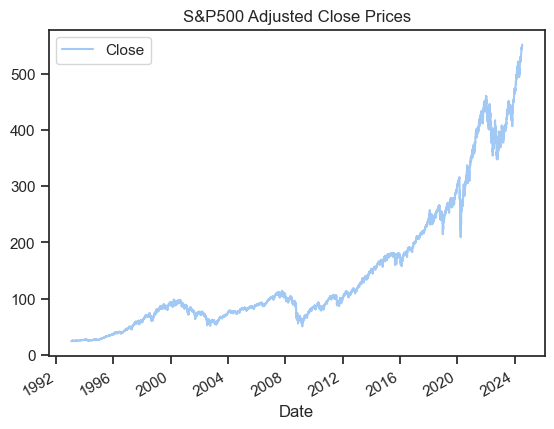

In [3]:
# Read S&P historical adjusted prices
ticker = 'SPY'
sp500 = (
    yf
    .Ticker(ticker)
    .history(period = 'max')
    # .reset_index()
    .loc[:, ['Close']]
)

# Check data
display(sp500.head())
sp500.plot(title = 'S&P500 Adjusted Close Prices')
plt.show()

In [4]:
# For backtest purposes, we fill non-working days with last prices
backtest_df = (    
    pd
    .DataFrame(index = pd.date_range(sp500.index.min(), sp500.index.max()))
    .rename_axis('Date')
    .merge(sp500, left_index = True, right_index = True, how = 'left')
    .ffill()
)

## Repeated Experiments for Generalizability

Suppose if we wanted to start investing but have no idea which strategy and its accompanying parameters would be most optimal, one way is to pick a random point to start investing, execute the investment strategy, compute its returns and compare between strategies. However, one random point is likely to be inconclusive as one strategy may prevail due to pure randomness. As such, we pick 1,000 random start points, compute the returns of each strategy and its accompanying parameters and evaluate its effectiveness to generalize our conclusions.

Below, we run the following experiment:

1. Pick a random start point of our investment period
2. Fetch prices at start to end of investment period
3. Execute investment strategies (LS and DCA)
4. Compute returns
5. Store results for further evaluation

The parameters of the experiment are as follows:

1. **Investment periods**: How long to keep the investment position, in number of years
2. **DCA periods**: How many months should money be equally invested for a DCA strategy

In [5]:
# Define experiment parameters
timepoints = backtest_df.index.to_numpy() # All possible timepoints to start investing
starting_cash = 100000
bootstraps = 1000 # Number of random start points
investment_periods = [1, 3, 5, 10, 15, 20] # How long to keep position, in years
dca_periods = np.arange(1, 5+1, 4)*12 # DCA periods for 1 year vs 5 years

In [6]:
# Define functions to invest money, calculate returns
def invest(prices, invest_dates, amount):
    df = prices.copy() # Make a copy of prices before replacing its values
    df.loc[lambda x: x.index.isin(invest_dates), 'invested'] = float(amount) / float(len(invest_dates)) # Invest equal amounts per period
    return df

def compute_returns(df):
    invested = df.invested.sum()
    absolute_return = (df.invested * (1 + df.returns)).sum() - df.invested.sum()
    end_cash = df.invested.sum() + absolute_return
    relative_return = (df.invested * (1 + df.returns)).sum() / df.invested.sum() - 1

    return [invested, end_cash, absolute_return, relative_return]

In [7]:
# Backtest
results = []
for investment_period in investment_periods:
    for _ in range(bootstraps):
        # Get key points
        max_start_point = timepoints.max() - pd.DateOffset(years = investment_period) # Ensure investment period doesn't exceed data period
        possible_start_points = timepoints[timepoints <= max_start_point]
        start_point = np.random.choice(possible_start_points)
        end_point = start_point + pd.DateOffset(years = investment_period)

        # Get prices
        prices = (
            backtest_df
            .loc[lambda x: (x.index >= start_point) & (x.index <= end_point)]
            .assign(
                returns = lambda x: x.iloc[-1].Close / x.Close - 1, # Compute relative returns of the last investment date to each possible start date
                invested = 0.00,
            )
            .copy()
        )

        # Invest lump-sum, compute returns and store its results
        lump_sum = invest(prices, [start_point], starting_cash)
        ls_returns = compute_returns(lump_sum)
        results.append([start_point, end_point, investment_period, 'LS', starting_cash,] + ls_returns)

        # Invest DCA, compute returns and store its results
        for dca_period in dca_periods:
            invest_dates = pd.date_range(start_point, start_point + pd.DateOffset(months = dca_period), freq = 'BME') # Business month end DCA investment where salaries are likely to be paid out
            dca = invest(prices, invest_dates, starting_cash)
            dca_returns = compute_returns(dca)
            results.append([start_point, end_point, investment_period, f'DCA{dca_period}', starting_cash, ] + dca_returns)

In [8]:
# Store results
backtest = (
    pd
    .DataFrame(
        np.array(results), 
        columns = ['start_date', 'end_date', 'years', 'strategy', 'start_cash', 'invested', 'end_cash', 'abs_return', 'pct_return'],
    )
)

display(backtest.shape)
display(backtest.sample(3))

(18000, 9)

,start_date,end_date,years,strategy,start_cash,invested,end_cash,abs_return,pct_return
2396,2012-10-13 00:00:00-04:00,2013-10-13 00:00:00-04:00,1,DCA60,100000,"20,000.00","22,213.67","2,213.67",0.11
17964,2002-09-29 00:00:00-04:00,2022-09-29 00:00:00-04:00,20,LS,100000,"100,000.00","643,689.20","543,689.20",5.44
3774,2020-06-13 00:00:00-04:00,2023-06-13 00:00:00-04:00,3,LS,100000,"100,000.00","150,263.52","50,263.52",0.50


The sample table collects the observations from executing the investment strategies with varying parameters from 1,000 random startpoints. Given there are 3 primary strategies (*LS/DCA12/DCA60; DCAxx suggests a DCA strategy with equal investment over a period of xx months*) and 6 investment periods, we generate 18 strategy combinations over 1,000 experiments resulting in 18K observations.

In the next section, we evaluate each combination for its returns to offer a deterministic conclusion using randomness as an experiment strategy.

## Results

Below, we plot each combination's returns over 1,000 experiments as we observe increasing investment periods, where returns is simply computed as such:

$\text{\% returns} = \frac{\text{cash at end period}}{\text{invested cash}} - 1$

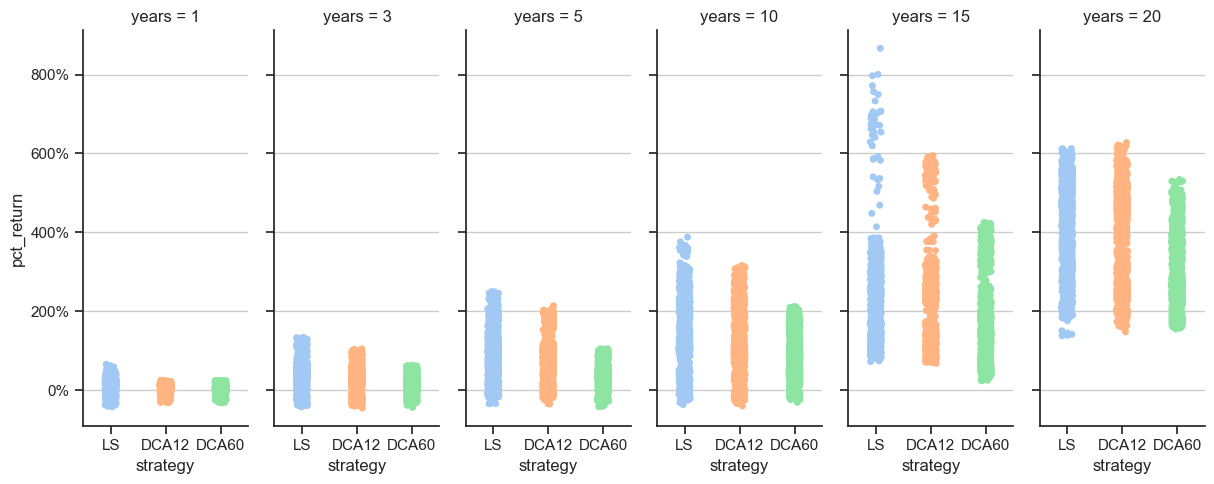

In [9]:
# Compare by investment years and strategy
g = sns.catplot(data = backtest, x = 'strategy', y = 'pct_return', hue = 'strategy', col = 'years', aspect = 0.4)

# Set grid and y-axis to percentage
for i, ax in enumerate(g.axes.flatten()):
    ax.grid(visible = True, axis = 'y')
    if i == 0:
        labels = [f'{x:.0%}' for x in ax.get_yticks()]
        ax.set_yticklabels(labels)

# Show plot
plt.show()

The distributions prove that regardless of strategies, holding an investment in S&P500 for $\geq$ 15 years generates a positive return, **even in the worst case scenario** where all experiments observed a positive return. This conclusion proves the conventional wisdom that "time in the market" prevails, i.e. keeping a position for a long time in a market index like S&P500 always generate positive returns.

Below, we report statistics for each combination, in further detail.

In [10]:
# Report 99% CI statistics
confidence = 99
stats = (
    backtest
    .groupby(['strategy', 'years'])
    .agg(
        {
            'pct_return': ['mean', 'min', 'max', lambda x: np.percentile(x, 100-confidence), lambda x: np.percentile(x, confidence)]
        }
    )
    .reset_index()
    .set_axis(['strategy', 'years', 'expected_return', 'min', 'max', f'lower_{100-confidence}%', f'upper_{confidence}%'], axis = 1)
    .pivot_table(index = 'years', columns = 'strategy', values = ['expected_return', f'lower_{100-confidence}%', f'upper_{confidence}%'])
    + 1
)

display(stats)

expected_return            lower_1%            upper_99%           
strategy           DCA12 DCA60   LS    DCA12 DCA60   LS     DCA12 DCA60   LS
years                                                                       
1                   1.05  1.05 1.11     0.73  0.73 0.62      1.22  1.22 1.47
3                   1.31  1.18 1.38     0.61  0.69 0.64      1.99  1.60 2.26
5                   1.61  1.31 1.70     0.79  0.72 0.83      2.99  1.99 3.37
10                  2.24  1.87 2.35     0.73  0.82 0.77      4.07  3.03 4.57
15                  3.15  2.81 3.23     1.72  1.32 1.81      6.78  5.12 8.03
20                  4.74  3.94 4.98     2.77  2.64 2.88      7.00  6.07 7.01

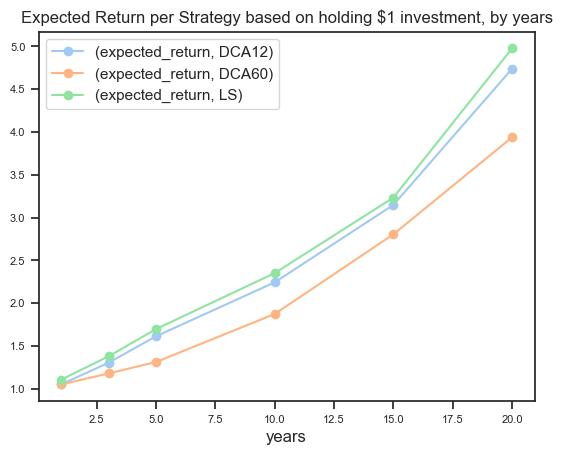

In [11]:
# Plot each strategy's growth based on $1 investment
(
    stats
    .iloc[:, :3]
    .plot(marker = 'o', fontsize = 8, title = 'Expected Return per Strategy based on holding $1 investment, by years')
)
plt.legend(title = None)
plt.show()

Suppose if we invested \$1 using each strategy for the given number of investment years, the table above summarizes each combination's expected returns and its respective worst/best case scenarios at 99\% confidence intervals. As consistent from the earlier visualizations, $\geq$ 15 years of holding an S&P500 position will result in a positive return even in a worst case scenario. From an expectation perspective, i.e. mean of 1,000 randomized controlled trials (RCTs), each strategy generates positive returns regardless of number of investment years.

When comparing between strategies, **lump sum (LS) investing appears to outperform dollar-cost averaging (DCA)** in expectation for all investment periods (*see plot above*). DCA outperforms in worst case scenarios in the low investment periods and may be a suitable strategy for short to mid-term, risk-averse investors who are looking to minimize any potential losses while generating a slightly sub-par return as compared to LS.

## Bonus: Berkshire Hathaway Class B vs S&P500

Since Warren Buffett's investment picks are reliant on safe (*big-cap*), quality (*profitable*) and undervalued stocks, many of such picks would belong in the S&P500 basket of companies. This raises the question: If we were to default to LS investing as a strategy for a long-term investment period, which of **`BRKB`** or **`SPY`** would be a better position to hold for the long-run?

Using a similar experiment approach as earlier, below we evaluate the two picks over 1,000 RCTs.

In [12]:
# Read BRK.B historical adjusted prices
ticker = 'BRK-B'
brkb = (
    yf
    .Ticker(ticker)
    .history(period = 'max')
    .loc[:, ['Close']]
)

In [13]:
# Fill forward for non-trading days in both tickers
brkb_df = (    
    pd
    .DataFrame(index = pd.date_range(brkb.index.min(), brkb.index.max()))
    .rename_axis('Date')
    .merge(brkb, left_index = True, right_index = True, how = 'left')
    .ffill()
)
spy_df = (    
    pd
    .DataFrame(index = pd.date_range(sp500.index.min(), sp500.index.max()))
    .rename_axis('Date')
    .merge(sp500, left_index = True, right_index = True, how = 'left')
    .ffill()
)

In [14]:
# Define experiment parameters
timepoints = brkb_df.index.to_numpy() # All possible timepoints to start investing
starting_cash = 100000
bootstraps = 1000 # Number of random start points
investment_period = 15

In [15]:
# Run RCTs
results = []
prices_dict = {'BRK-B': brkb_df, 'SPY': spy_df}

for _ in range(bootstraps):
    # Get key points
    max_start_point = timepoints.max() - pd.DateOffset(years = investment_period) # Ensure investment period doesn't exceed data period
    possible_start_points = timepoints[timepoints <= max_start_point]
    start_point = np.random.choice(possible_start_points)
    end_point = start_point + pd.DateOffset(years = investment_period)
    
    for ticker, df in prices_dict.items():
        # Fetch prices
        prices = (
            df
            .loc[lambda x: (x.index >= start_point) & (x.index <= end_point)]
            .assign(
                returns = lambda x: x.iloc[-1].Close / x.Close - 1, # Compute relative returns of the last investment date to each possible start date
                invested = 0.00,
            )
            .copy()
        )

        # Invest lump-sum, compute returns and store its results
        lump_sum = invest(prices, [start_point], starting_cash)
        ls_returns = compute_returns(lump_sum)
        results.append([start_point, end_point, investment_period, 'LS', ticker, starting_cash,] + ls_returns)


# Store results
backtest = (
    pd
    .DataFrame(
        np.array(results), 
        columns = ['start_date', 'end_date', 'years', 'strategy', 'ticker', 'start_cash', 'invested', 'end_cash', 'abs_return', 'pct_return'],
    )
)

display(backtest.shape)
display(backtest.sample(3))

(2000, 10)

,start_date,end_date,years,strategy,ticker,start_cash,invested,end_cash,abs_return,pct_return
303,2000-06-21 00:00:00-04:00,2015-06-21 00:00:00-04:00,15,LS,SPY,100000,"100,000.00","188,757.11","88,757.11",0.89
451,2007-08-22 00:00:00-04:00,2022-08-22 00:00:00-04:00,15,LS,SPY,100000,"100,000.00","378,891.77","278,891.77",2.79
839,2006-02-06 00:00:00-05:00,2021-02-06 00:00:00-05:00,15,LS,SPY,100000,"100,000.00","414,121.35","314,121.35",3.14


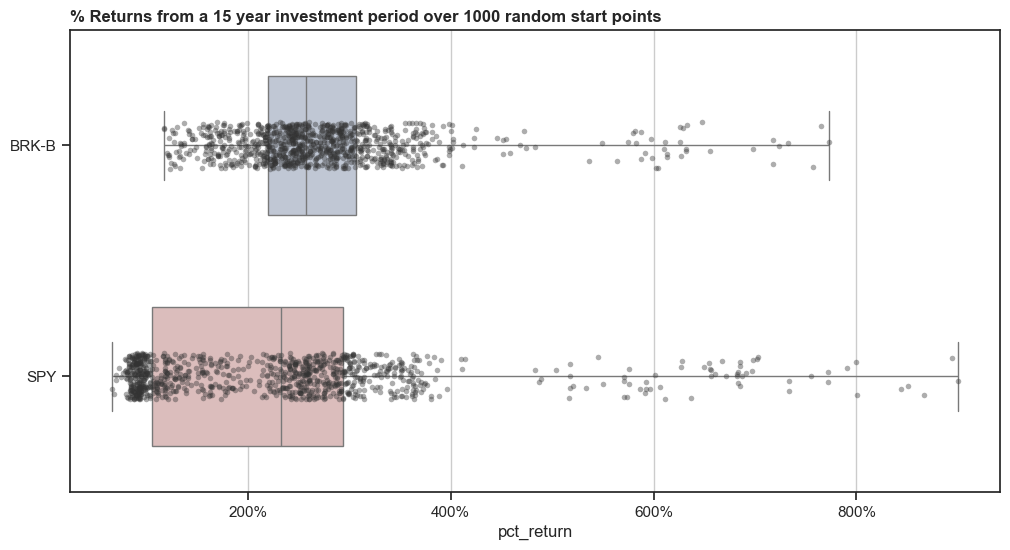

In [16]:
# Initialize the figure
f, ax = plt.subplots(figsize=(12, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(
    backtest, x="pct_return", y="ticker",
    whis=[0, 100], width=.6, palette="vlag"
)

# Add in points to show each observation
sns.stripplot(backtest, x="pct_return", y="ticker", size=4, color=".2", alpha = 0.4)

# Tweak the visual presentation
ax.set_title('% Returns from a 15 year investment period over 1000 random start points', fontweight = 'bold', loc = 'left')
ax.xaxis.grid(True)
ax.set(ylabel="")
labels = [f'{x:.0%}' for x in ax.get_xticks()]
ax.set_xticklabels(labels)
plt.show()

In [17]:
# Report 99% CI statistics
confidence = 99
stats = (
    backtest
    .groupby(['ticker', 'years'])
    .agg(
        {
            'pct_return': ['mean', 'min', 'max', lambda x: np.percentile(x, 100-confidence), lambda x: np.percentile(x, confidence)]
        }
    )
    .reset_index()
    .set_axis(['strategy', 'years', 'expected_return', 'min', 'max', f'lower_{100-confidence}%', f'upper_{confidence}%'], axis = 1)
    .pivot_table(index = 'years', columns = 'strategy', values = ['expected_return', f'lower_{100-confidence}%', f'upper_{confidence}%'])
    + 1
)

display(stats)

expected_return      lower_1%      upper_99%     
strategy           BRK-B  SPY    BRK-B  SPY     BRK-B  SPY
years                                                     
15                  3.73 3.32     2.27 1.80      7.33 8.55

Our analysis shows strong support for believing that `time in the market` outperforms `timing the market` as lump sum (LS) investing outperforms DCA signfiicantly in most scenarios. 

In the case of holding a position between tickers (`SPY` vs `BRKB`), it appears that `BRKB` may have a higher than expected return against the market which shows Warren Buffett's investment strategy does hold validity. In a highly bullish market (best case scenario), such strategy might underperform the market while it does offer wealth protection in a bearish market (worst case scenario) since Buffett's strategy to pick safe stocks will limit losses. 

In general, `BRKB` has a higher mean with lower variance, i.e. higher Sharpe ratio, which is a better position to hold when evaluated on that metric over an investment period of 15 years.